# What drives the price of a car?


## Business Understanding

The objective of this project is to develop a predictive model to analyze and determine the most significant factors influencing used vehicle prices. We would like to understand what factors make a vehicle more or less expensive and provide a clear recommendation to the client -- a used car dealership -- as to what consumers value in a used car.

## Data

The original dataset contained 3M vehicles, however we are provided with information on 426K cars, including various attributes such as condition, odometer reading, year, and more. The goal is to develop a predictive model to help a used car dealership understand what consumers value in a used car.


## Data Gathering and understanding

1. Read CSV
2. Understand data structure and independent variables
3. Determine missing values and explore the right strategy for treating them (drop columns or rows, and filling missing values - mode, mean or use KNN)
4. Understand categorical variables
 

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import root_mean_squared_error

import time


In [313]:
# read vehicles data

vehicles = pd.read_csv('data/vehicles.csv')

print("Number of rows and columns in the dataset:", vehicles.shape)


Number of rows and columns in the dataset: (426880, 18)


In [314]:
# In summary, below steps will include

# Review vehicles information (id, region, price, year, model, cyliners, odometer etc)
# Check of the summary statistics of price, year, and odometer. Identified unique and missing values.
# Collection of descriptive statistics of categorical variables (cylinders, fuel, title_status, transmisson, VIN, drive, size, type, paint_color_state)
# Cleaning the data (handling missing values, removing duplicates)
# Removed ID, VIN
# Removed regio, model, state categorical columns with large unique values
# Removed size as it had large amount of missing data
# Dropped duplicate rows 
# Converted data type of cyliner to a numerical value
# Removed outliers (price, odometer, year) colums

In [315]:
# review the columns in the data set 

vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [319]:
# check the summary statistics of the numerical values

vehicles[['price', 'year', 'odometer']].describe()  

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


* The `price, odometer and year` columns have a wide range of data. There is a vehicle with a `price max of 3 billion`, and odometer readings of `1M`. Both the odometer reading of 1M miles and 3Billion price for an individual car (even antique) looks unreasonable and an outlier. For the purposes of this analysis we will need to `treat outliers` (odometer readings about 500k and prices above 100k)

In [322]:
# unique values per column

vehicles.nunique()

id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64

In [323]:

# Determine missing values

vehicles.isna().mean().round(4)*100


id               0.00
region           0.00
price            0.00
year             0.28
manufacturer     4.13
model            1.24
condition       40.79
cylinders       41.62
fuel             0.71
odometer         1.03
title_status     1.93
transmission     0.60
VIN             37.73
drive           30.59
size            71.77
type            21.75
paint_color     30.50
state            0.00
dtype: float64

In [325]:
#Descriptive statistics for categorical variables

vehicles.describe(include=['object', 'category'])

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880,409234,421603,252776,249202,423867,418638,424324,265838,296313,120519,334022,296677,426880
unique,404,42,29649,6,8,5,6,3,118246,3,4,13,12,51
top,columbus,ford,f-150,good,6 cylinders,gas,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,3608,70985,8009,121456,94169,356209,405117,336524,261,131904,63465,87056,79285,50614


### * Categorical variables: The columns `region`, `manufacturer`, `model`, and `state` have a large number of unique values, requiring an appropriate strategy for treatment.
* VIN numbers: There are only 265838 unique VIN numbers in a dataset of 426880 observations, indicating possible duplicate entries.
* Missing values: The columns `condition`, `cylinders`, `VIN`, `drive`, `size`, `type`, and `paint_color` have more than 25% missing values.
* The `price, odometer and year` columns have a wide range of data. There is a vehicle with a `price max of 3 billion`, and odometer readings of `1M`. Both the odometer reading of 1M miles and 3Billion price for an individual car (even antique) looks unreasonable and an outlier. For the purposes of this analysis we will need to `treat outliers` (odometer readings about 500k and prices above 100k)

## Data Quality / Clean up

After an initial review of data, the following data quality and clean up steps are undertaken:

1. Remove irrelevant data: IDs, VINs
2. Remove categorical columns with a large number of unique values (region, model, state) - These can be added back after the first pass of model creation if needed
3. Remove columns with more than 50% missing data (size)
4. Drop duplicate rows
5. Convert data types:
    - Extract the number of cylinders as a numerical value
6. Perform outlier analysis and removal for the price, odometer, and year columns



In [329]:

# remove object columns that we intuitively know to be not related to the price of a used car such as id, VIN
vehicles_clean = vehicles.drop(columns = ['id', 'VIN'])

# remove categorical variables with very large unique values - region(404), model(29649), state(51). This may be reintroduced later 
# if do not find any other variables that can help build a good model
vehicles_clean = vehicles_clean.drop(columns = ['region', 'model', 'state'])

# remove columns with > 50% missing values
vehicles_clean = vehicles_clean.drop(columns = ['size'])

# drop duplicates
vehicles_clean = vehicles_clean.drop_duplicates()

vehicles_clean.shape

(244870, 12)

In [330]:

# convert cylinders to numeric values
vehicles_clean['cylinders'] = vehicles_clean['cylinders'].str.replace('cylinders', '', regex=False)
vehicles_clean['cylinders_numeric'] = pd.to_numeric(vehicles_clean['cylinders'], errors='coerce', downcast='integer')
print(vehicles_clean['cylinders_numeric'].value_counts())

vehicles_clean.drop(columns = 'cylinders', inplace=True)


cylinders_numeric
4.0     56018
6.0     55892
8.0     41499
5.0      1355
10.0      717
3.0       449
12.0      153
Name: count, dtype: int64


In [331]:

# Address outliers in price, odometer and year columns
#

vehicles_clean = vehicles_clean[(vehicles_clean['price'] > 1) & (vehicles_clean['price'] < 100000)]
vehicles_clean = vehicles_clean[(vehicles_clean['odometer'] > 1) & (vehicles_clean['odometer'] < 500000)]
vehicles_clean = vehicles_clean[(vehicles_clean['year'] > 1925)]

vehicles_clean.select_dtypes(include=['float64', 'int64']).describe()


,price,year,odometer,cylinders_numeric
count,221743.000000,221743.000000,221743.000000,145727.000000
mean,15242.084242,2009.227101,106302.715829,5.809075
std,13213.883375,10.478521,64293.010759,1.609941
min,2.000000,1926.000000,2.000000,3.000000
25%,5987.000000,2006.000000,56616.500000,4.000000
50%,11000.000000,2012.000000,101977.000000,6.000000
75%,20590.000000,2016.000000,148000.000000,8.000000
max,99999.000000,2022.000000,499232.000000,12.000000


In [332]:

print('The shape of the cleaned dataset is:', vehicles_clean.shape)

The shape of the cleaned dataset is: (221743, 12)


In [334]:
# check the percentages of missing values after initial clean up

vehicles_clean.isna().mean().round(4)*100

price                 0.00
year                  0.00
manufacturer          3.85
condition            37.52
fuel                  0.55
odometer              0.00
title_status          1.59
transmission          0.37
drive                27.64
type                 25.03
paint_color          28.70
cylinders_numeric    34.28
dtype: float64

## Exploratory Data Analysis (EDA)


In [336]:
# Helper function to create seaborn plots that share the same appearance attributes
#   such as: heading, title, x-y labels, and placement of the legend
# 
def render_plot(ax, heading='', subtitle='', xlabel='', ylabel='', rotation=20, plotname='',displaybarlabel=True):
    
    plt.suptitle(heading, fontsize = 18)                        # main heading of the plot
    plt.title(subtitle, fontsize = 12)                          # sub title of the plot
    
    ax.set(xlabel=xlabel, ylabel=ylabel)                        # x and y labels
    
    if displaybarlabel == True:
        for i in ax.containers:
            ax.bar_label(i,)                                    # display values on bars
        
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
        
    for patch in ax.patches:                                    # remove bars that do not have any values
        if patch.get_height() == 0: 
            patch.set_visible(False)
    
    if ax.get_legend():                                         # if legend is present, set the location to upper right
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))     
        
    ax.tick_params(rotation=rotation, axis='x')                 # rotate the labels
    
    if len(plotname) > 0:
        filename = 'plots/' + plotname
        ax.get_figure().savefig(filename, bbox_inches='tight')
    

# Set palette and grid style
# 
sns.set_palette('pastel')
sns.set_style("whitegrid")

### EDA for Numerical Variables

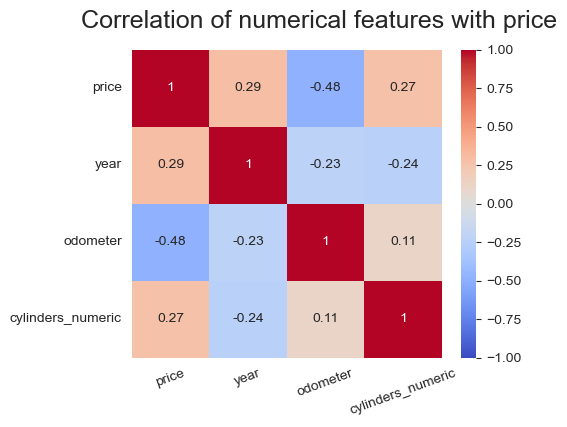

In [338]:

# Create a correlation heatmap using numerical features

plt.figure(figsize=(5, 4))
ax = sns.heatmap(vehicles_clean.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

render_plot(ax, heading = 'Correlation of numerical features with price', subtitle = '', 
            xlabel = '', 
            ylabel = '',
            plotname = '1-numerical_corr.png')


**Correlation Plot Analysis**

- **Price and Odometer**: There is a moderate negative correlation between price and odometer reading (-0.41). This indicates that as the odometer reading increases, the price of the car tends to decrease. This is expected as cars with higher mileage are generally less expensive.

- **Price and Cylinders**: There is a positive correlation between price and the number of cylinders (0.25). This suggests that cars with more cylinders tend to be priced higher. This could be due to the fact that cars with more cylinders are used for special purposes, and perhaps even be considered premium

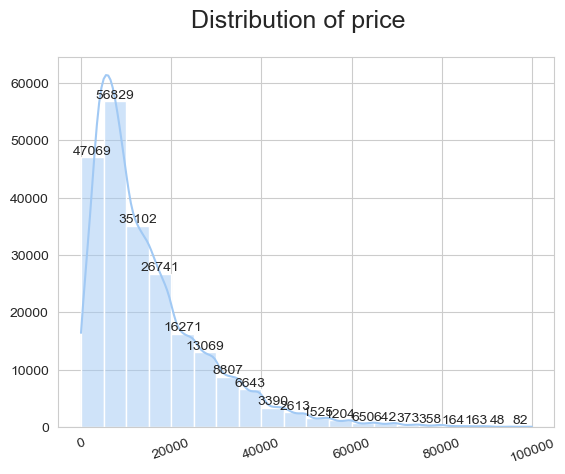

In [341]:
# Histogram/Barplots for numerical variables

ax = sns.histplot(data=vehicles_clean, x='price', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of price', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '2-Distribution-by-price.png')            



Used car prices typically follow a right-skewed distribution, meaning most cars are priced on the lower end, while a few high-end models drive up the maximum price range. The median price is often much lower than the mean due to expensive outliers.

Outliers - Some listings have extremely low prices (e.g., $0, $1, or a few hundred dollars), which may be incorrect or refer to damaged/salvage vehicles or placeholder prices.

Most competitive price range - The majority of used cars fall between $5,000 and $25,000, suggesting that this is the most competitive price range. 

Vehicles below $5000 are often older cars or high mileage, while those above $25,000 are usually newer models or premium brands.

Newer vehicles (e.g., 2018 and later) tend to be priced significantly higher. Vehicles with low mileage (<50K miles) are priced higher, while those exceeding 150K miles see a steep decline in value.

On the higher end, luxury models or rare vehicles can significantly raise the maximum price to $100,000+.


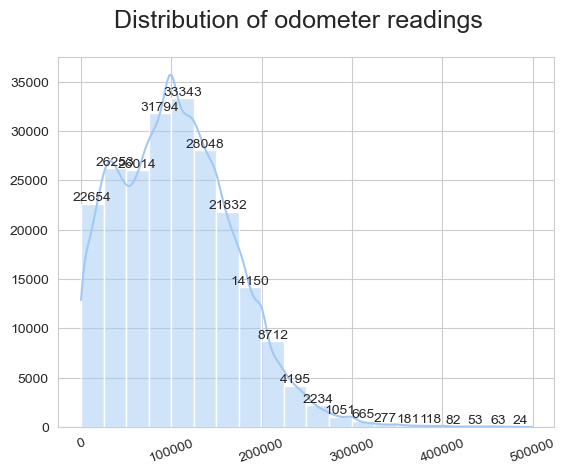

In [345]:
ax = sns.histplot(data=vehicles_clean, x='odometer', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of odometer readings', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '2-Distribution-by-odometer-readings.png')

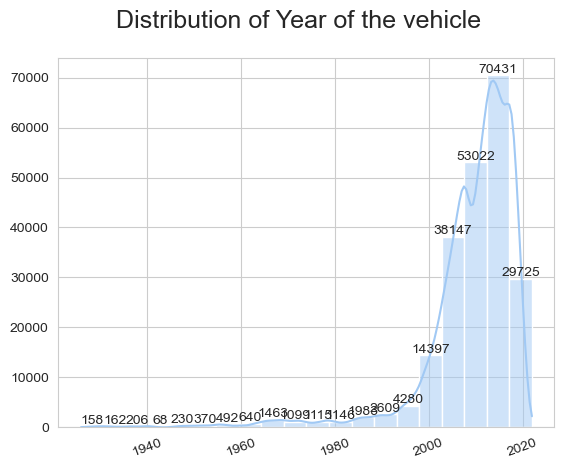

In [347]:
ax = sns.histplot(data=vehicles_clean, x='year', bins=20, kde=True)
render_plot(ax, heading = 'Distribution of Year of the vehicle', subtitle = '', 
            xlabel = '', ylabel = '', plotname = '3-Distribution-by-year-readings.png')

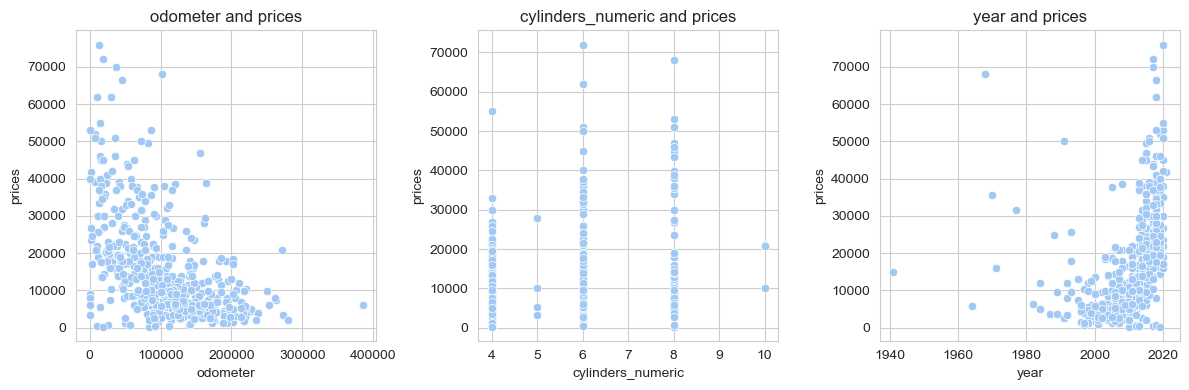

In [350]:
# Use a sample from the data set for the scatter plot. This is to avoid cluttering the plot with too many points
# 

np.random.seed(42)
df_numeric_sample = vehicles_clean.sample(500)


numerical_columns = ['odometer', 'cylinders_numeric', 'year']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(numerical_columns):
    ax = sns.scatterplot(x=df_numeric_sample[column], y=df_numeric_sample['price'], ax=axes[i])
    axes[i].set_title(f'{column} and prices')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('prices')

plt.tight_layout()
plt.savefig('plots/4-Scatterplot-odometer-cylinders-year-vs-prices.png')
plt.show()

* It appears that as age and odometer of the car increases the price goes down
* Price and Cylinders : There is a positive correlation between price and the number of cylinders (0.25). This suggests that cars with more cylinders tend to be priced higher. This could be due to the fact that cars with more cylinders are used for special purposes, and perhaps even be considered premium
* * Cars with 6-8 cylinders appear to get more price
* As expected newer model vehicles command a higher value. There are exceptions with older year vehicles that require further investigation.

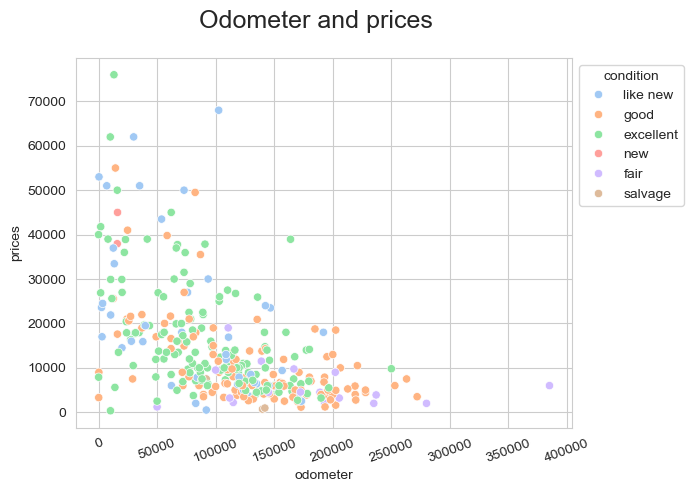

In [352]:
ax = sns.scatterplot(x=df_numeric_sample['odometer'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

render_plot(ax, heading = 'Odometer and prices', subtitle = '',
            xlabel = 'odometer', ylabel = 'prices', plotname = '4-Odometer_vs_prices.png')

* `Odometer and prices show an inverse relationship`: vehicles with in excellent, like new and new condition appear to be valued more than other conditions, given similar odometer readings

cylinders_numeric
4.0     11767.145161
5.0     11610.250000
6.0     15009.228070
8.0     17555.886076
10.0    17298.000000
Name: price, dtype: float64


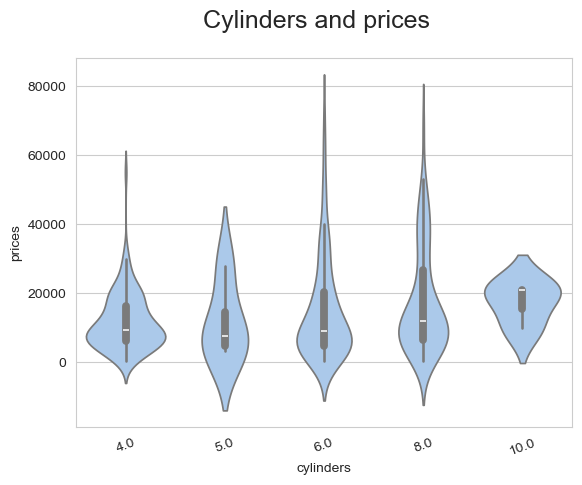

In [355]:
ax = sns.violinplot(x=df_numeric_sample['cylinders_numeric'], y=df_numeric_sample['price'])
ax.set_title('Cylinders and prices')

render_plot(ax, heading = 'Cylinders and prices', subtitle = '',
            xlabel = 'cylinders', ylabel = 'prices', plotname = '5-Cylinders_vs_prices.png')

print(df_numeric_sample.groupby('cylinders_numeric')['price'].mean())


cylinders_numeric
4.0     11767.145161
5.0     11610.250000
6.0     15009.228070
8.0     17555.886076
10.0    17298.000000
Name: price, dtype: float64


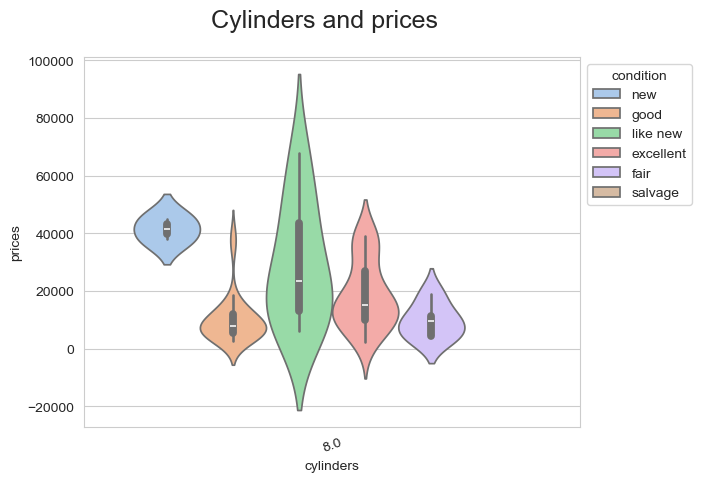

In [356]:
cylinders8_df_x = df_numeric_sample[df_numeric_sample['cylinders_numeric'] == 8]['cylinders_numeric']

# print(type(cylinders8_df))

ax = sns.violinplot(x=cylinders8_df_x, y=df_numeric_sample['price'],  hue=df_numeric_sample['condition'])

ax.set_title('Cylinders and prices')

render_plot(ax, heading = 'Cylinders and prices', subtitle = '',
            xlabel = 'cylinders', ylabel = 'prices', plotname = '5-8-Cylinders_vs_prices.png')

print(df_numeric_sample.groupby('cylinders_numeric')['price'].mean())

* `number of cylinders and prices show an positive relationship`: within vehicles with 8 cylinders, vehicles with new/like new condition sell for more

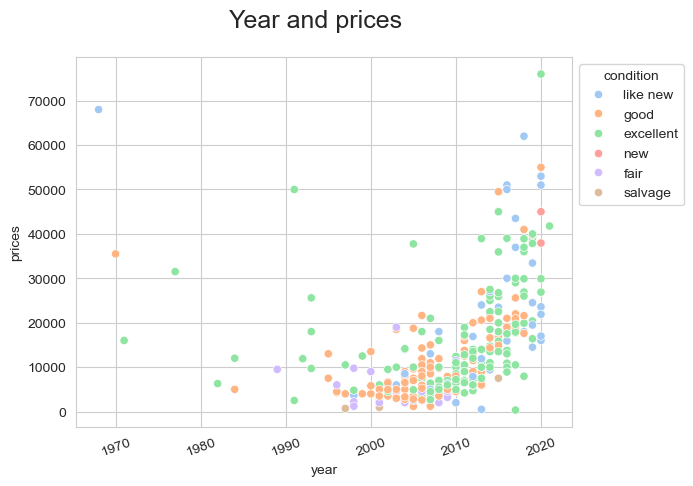

In [358]:
ax = sns.scatterplot(x=df_numeric_sample['year'], y=df_numeric_sample['price'], hue=df_numeric_sample['condition'])

render_plot(ax, heading = 'Year and prices', subtitle = '',
            xlabel = 'year', ylabel = 'prices', plotname = '6-Year_vs_prices.png')



* Years and prices: newer vehicles appear to command higher prices : There are situations such as a like new car that is year 1970 at the top of the chart. This may be an error in the data set or the car never have been driven

### EDA for Categorical Variables

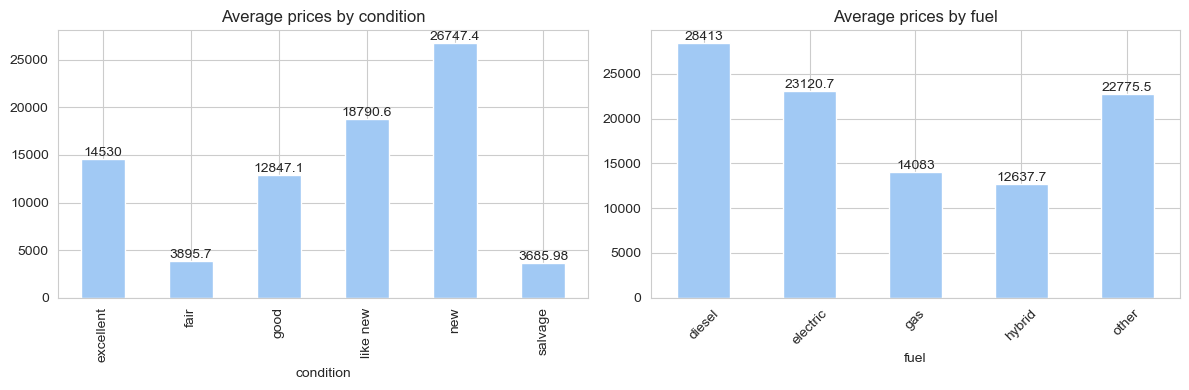

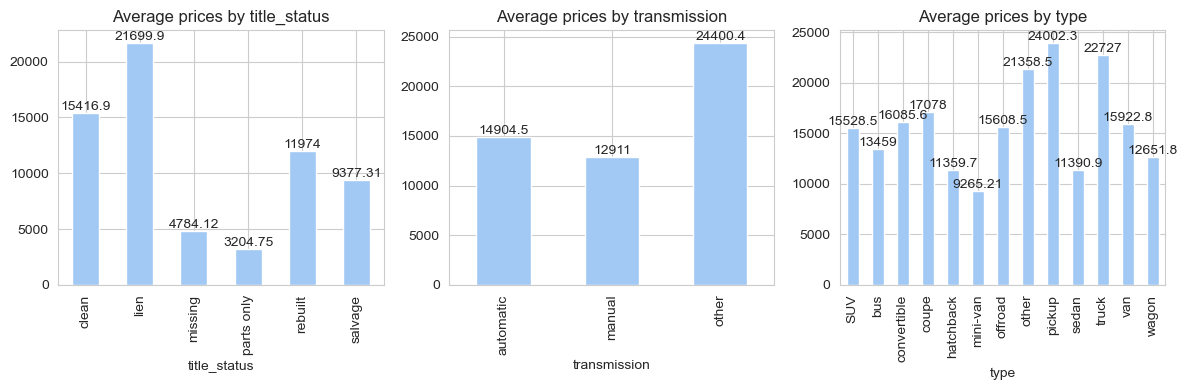

In [362]:

# Explore the price with categorical variables
#

categorical_columns = ['condition',  'fuel']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].bar_label(axes[i].containers[0])

fig.savefig('plots/7-Average_prices_by_condition_fuel.png', bbox_inches='tight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

categorical_columns = ['title_status', 'transmission', 'type']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, column in enumerate(categorical_columns):
    mean_costs = vehicles_clean.groupby(column)['price'].mean()
    mean_costs.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average prices by {column}')
    axes[i].set_xlabel(column)
    axes[i].bar_label(axes[i].containers[0])

fig.savefig('plots/8-Average_prices_by_title_status_transmission_type.png', bbox_inches='tight')
plt.tight_layout()
plt.show()



* Vehicles with condition `(New/Like New)` tend to be priced higher. On the other hands cars with `salvaged` condition tend to be priced the lowest
* `Pickups` tend to attract higher prices, mini-vans on the other hand appear to sell for less
* `Diesel` vehicles tend to attract higher prices
* Vehicles with more `cylinders` are more expensive


## Data Preparation before modeling

After our initial exploration and fine-tuning of the business understanding, we will construct our final dataset prior to modeling.  We will handle integrity issues and cleaning. 

#### Pre-processing

1. Split the data into train/test sets, before imputing any of the missing values
2. Standardize and scale the data using StandardScaler()


In [366]:
# Split the data into train test

X = vehicles_clean.drop(columns = 'price')
y = vehicles_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((177394, 11), (44349, 11))

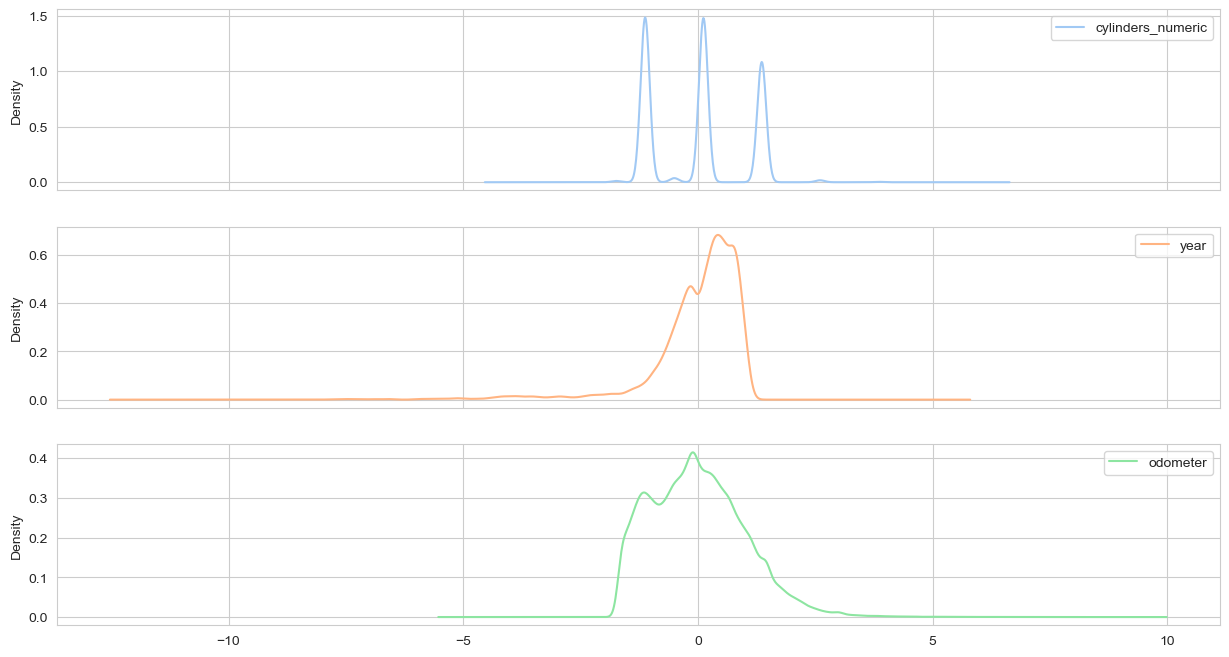

In [367]:
# initiate the Standard Scaler. this is for exploratory purposes. we will use a eventually pipeline to scale the data
# plot the kernet densities of the scaled numerical features. Pipeline will also help in imputing null values
# 
num_features = ['cylinders_numeric', 'year', 'odometer']   

scale = StandardScaler()

X_train_transformed = pd.DataFrame(scale.fit_transform(X_train[num_features]), \
    columns = scale.get_feature_names_out())

X_train_transformed.plot(kind = 'kde', subplots = True,figsize = (15,8));


## Modeling

* Build models for  both numerical, and numerical+categorical variables. The numerical model will have polynomial, and categorical will have OHE and ordinal encoders.
* Explore changing the degree of the polynomial features to determine the best degree for the model
* Document and compare the evaluations for each model
* Recommend the model to the dealership and suggestions for next steps

In [370]:
# helper functions to run and evaluate Linear Regression, Lasso and Ridge models
#

# Create an emptry data frame to store ther results of various models evaluated
#
models_evaluated = pd.DataFrame()

# helper functions to fit and retrieve the evaluation metrics from a given model
#
def eval_model_linear (pipeline, regression_type, feature_type, poly_degree=2, model_index=''):
    
    start_time = time.time()
    
    pipeline.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(pipeline.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(pipeline.predict(X_test), y_test)
    feature_names = pipeline[:-1].get_feature_names_out()
    number_of_features = len(feature_names)
    r2_test = pipeline.score(X_test, y_test)
    
    return ({'model index: ': model_index, \
            'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': number_of_features, \
            'degree': poly_degree, \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': 'n/a',
            'time to fit model (seconds):': elapsed_time})    
    

def eval_model_lasso_ridge (grid, regression_type, feature_type, poly_degree=1, model_index=''):
        
    start_time = time.time()

    grid.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    train_rmse = root_mean_squared_error(grid.predict(X_train), y_train)
    test_rmse = root_mean_squared_error(grid.predict(X_test), y_test)
    
    print("Best param: ", grid.best_params_)
    
    number_of_features = len(grid.best_estimator_.named_steps[regression_type].coef_)
    r2_test = grid.score(X_test, y_test)
    best_alpha = {list(grid.best_params_.values())[0]}
    
    return ({'model index: ': model_index, \
            'model': regression_type, \
            'feature_type': feature_type, \
            'number of features': number_of_features, \
            'degree': poly_degree, \
            'training rmse': train_rmse, \
            'testing rmse': test_rmse, \
            'r2 test data': r2_test, 
            'best_alpha': best_alpha, 
            'time to fit model (seconds):': elapsed_time})   

#### Step 1. Numerical features in the model

In [372]:
# Define the features of interest, these static values will be used in subsequent model evaluations
#
num_features = ['cylinders_numeric', 'year', 'odometer']       


In [373]:
# Step 1.1 Linear Regression model with numerical features only

model_index='1.11'
poly_degree = 1

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline


In [374]:
# Step 1.12 Linear Regression model with numerical features only

model_index='1.12'
poly_degree = 2

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline


In [375]:
# Step 1.13 Linear Regression model with degree 3

model_index = '1.13'
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linreg', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline


In [376]:
# Step 1.2 Ridge Regression model with numerical features only

model_index = '1.2'
param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge(fit_intercept=True))])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'ridge', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline



Best param:  {'ridge__alpha': 0.1}


In [377]:
# Step 1.3 Lasso Regression model with numerical features only

model_index = 1.3
param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

preprocessor = ColumnTransformer(transformers=[('numerical', numeric_transformer, num_features)])
pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(fit_intercept=True))])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict = eval_model_lasso_ridge(grid, 'lasso', 'All Numeric', poly_degree=poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline



Best param:  {'lasso__alpha': 1}


In [379]:
models_evaluated

,model index:,model,feature_type,number of features,degree,training rmse,testing rmse,r2 test data,best_alpha,time to fit model (seconds):
0,1.11,linear,All Numeric,3,1,10663.441428,10686.773965,0.345645,n/a,0.060400
1,1.12,linear,All Numeric,9,2,9626.263470,9662.716134,0.465043,n/a,0.114777
2,1.13,linear,All Numeric,19,3,9330.447622,9364.728926,0.497530,n/a,0.212546
3,1.2,ridge,All Numeric,19,3,9330.447622,9364.728893,0.497530,{0.1},4.174270
4,1.3,lasso,All Numeric,19,3,9330.449083,9364.741888,0.497528,{1},13.387304


A `degree 3` model appears to provide a much better result than a degree 1 model and slightly better than a degree 2 model

#### Step 2. Numerical and Categorical features in the model (with OHE encoding)

In [382]:
cat_features = ['condition', 'title_status', 'manufacturer', 'type', 'fuel']


In [383]:
# Step 2.1 Linear Regression with numerical and categorical columns

model_index = '2.1'
poly_degree = 3

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('LinearRegression', LinearRegression())])

dict= eval_model_linear(pipeline, 'Linear', 'Numerical and Categorical', poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
pipeline

selected_model = pipeline

In [387]:
# Step 2.2 Ridge Regression model with numerical and categorical features

model_index = '2.2'
poly_degree = 3

param_grid = {'ridge__alpha': [0.1, 1, 10, 100, 1000]}

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

grid = GridSearchCV(pipeline, param_grid=param_grid)

dict= eval_model_lasso_ridge(grid, 'ridge', 'Numerical and Categorical', poly_degree, model_index=model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline


Best param:  {'ridge__alpha': 1}


In [ ]:
# Step 2.3 Lasso Regression model with numerical and categorical features

model_index = '2.3'
poly_degree = 3
param_grid = {'lasso__alpha': [0.1, 1, 10, 100, 1000]}
cat_features = ['condition', 'title_status', 'type', 'fuel', 'manufacturer']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))])

categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical', categorical_transformer, cat_features)])

pipeline = Pipeline([('preprocessor', preprocessor), ('lasso', Lasso(max_iter=10000))])

# Change the default parameters for GridSearchCV for Lasso to avoid convergence warnings - change cross validation to 2, 
# and n_jobs to -1 (to use all processors)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=2, n_jobs=-1)

dict = eval_model_lasso_ridge(grid, 'lasso', 'Numerical and Categorical',poly_degree, model_index = model_index)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
# 
#pipeline



#### Step 3. Numerical and Categorical features in the model (with OHE and Ordinal encoding)

In [ ]:
# Try Ordinal value encoding and evaluate if that improves the model
# 
cat_features_nominal = ['manufacturer', 'type', 'fuel']
cat_features_ordinal = ['condition', 'title_status']

ordinal_data_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
    ['parts only', 'missing', 'salvage', 'rebuilt', 'lien', 'clean'],
]


In [ ]:
# Step 2.4 Linear Regression with numerical and categorical columns with Ordinal Encoding

model_index = '2.4'
poly_degree = 3
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False))
])

categorical_transformer_ordinal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ordinal', OrdinalEncoder(categories=ordinal_data_categories))])

categorical_transformer_nominal = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[('numerical', numeric_transformer, num_features),
                  ('categorical_ordinal', categorical_transformer_ordinal, cat_features_ordinal), 
                  ('categorical_nominal', categorical_transformer_nominal, cat_features_nominal)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),('linear', LinearRegression())])

dict = eval_model_linear(pipeline, 'linear', 'Numerical and Categorical incl Ordinal', model_index = model_index, poly_degree=poly_degree)
models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

#Commenting  print of pipeline object as it creates liveHTML which is not supported on Github and it messes up the formatting of the notebook
#
#pipeline


## Model Evaluation


This analysis used LinearRegression, Ridge and Lasso regresion models for the cleaned vehicle data set. The models evaluated were:
* Numerical columns only 
* Numerical and categorical columns 
* Numerical and categorical columns with both nominal and ordinal values

For each run of the model we captured the training rmse, test rmse, r2 score, alpha (if applicable) and time taken to fit the model. The summary of model evaluation is shown in the table below

In [ ]:
models_evaluated.set_index('model index: ', inplace=True)
models_evaluated

We observed the following with these models

* LinearRegression model, degree 1 for numerical features scored the lowest at 34%. A degree 2 model helped improve the score to 46% 
* Ridge, Lasso models for numerical features with degree 3 scored at 49%. GridSearchCV was used to find the best alpha values, indicated in the table
* LinearRegression model was further improved with additional of categorical variables. This helped improved the score to 61% (model index 2.1 above)
* Ridge, Lasso for numerical and categorical with OHE returned the same score as LinearRegression at 61%
* Finally a LinearRegression model with Numercial, Categorical (both OHE and ordinal) was created. The score did not improve with this model and remained at 61%

`Note`: on Lasso for numerical and categorical columns (model index 2.3). The model fit was taking a long time and providing convergence warnings, so I changed the default parameters for GridSearchCV: change cross validation to 2, # and n_jobs to -1 (to use all processors)

`Model Recommendation`: Considering there is no improvement using Lasso or Ridge regression and time cost of these regularization models are high, the recommendation is to use the `LinearRegression model with both numerical and categorical variables`. This is model index 2.1 in the above evaluation table

### Understanding the features that have the most impact on the price of the vehicle

In [ ]:
# Get the feature names from the preprocessor
feature_names = selected_model.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the final estimator
coefficients = selected_model.named_steps['LinearRegression'].coef_

# Create a DataFrame to display the feature names and their corresponding coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print("Top 20 features that have the most impact on increasing the price of the car")
print(coef_df.sort_values(by='Coefficient', ascending=False).head(20))

print("Top 20 features that have the most impact on lowering the price of the car")
print(coef_df.sort_values(by='Coefficient', ascending=True).head(20))

## Conclusions and recommendations

Based on the analysis, below are the key findings will help dealership make informed decisions about inventory acquisition and pricing strategies

- Stock vehicles in the $5,000 - $25,000 range to match customer demand. Most competitive price range 
- Prioritize low-mileage cars (<100K miles), as they retain higher value.
- Focus on popular manufacturers (Toyota, Audi, Ford) for better resale value.
- Offer SUVs & pickup trucks, as they have strong resale value.
- Consider more hybrid & electric models, given their premium pricing.
- On the higher end, luxury models or rare vehicles can significantly raise the maximum price to $100,000+. Good idea to plan a couple of luxury car sales each quarter targeting the luxury market for increased profitability and try being a new entrant to the luxury market.
- Key features that drive price (+vely/-vely) of an used car are manufacturer, fuel type, title_status, type, condition. These features make car more or less expensive in the used car market
- Positive price impact
Manufacturer (Ferrari, Tesla, Ashton Martin, Porsche), fuel type (Diesel), title (Lien), type (pickup), condition (like new)
- Negative price impact
Manufacturer (Fiat, Mitsubishi, Kia, Nissan, Chrysler), fuel type (Electric), title (parts only), type (bus, hatchback), condition (no/low maintenance)

# Next Steps & Recommendations

As an immediate next step as a car dealer, you can use the above Executive summary, key insights to make informed decisions about inventory acquisition and pricing strategies. Moving futher, we can look at improving the model performance (from current 61%) to higher predictions (80-90%) for used car pricing.

Note: 
- Typical ML models for car price prediction achieve 60%-90%
- 100% → Perfect Model (which IMO, is not attainable due to price variability nature of used car prices, market nuances, data limitations, ML model constraints)
- 0% → Model performs no better than predicting the mean price

We can improve the model performance using the following for better predictions

- Perform discovery of additional vehicles data set and identify new features (market trends, seller type, accident history, maintenance records, recalls etc)
- Gather additional vehicle data (size and volume), including location/demography based, consumer behavior while selecting used cars
- Use of dynamic pricing data from real-time market listings from used car market (carmax, carvana, edmunds)
- Encode categorical variables more effectively (One Hot Encoding)
- Feature scaling - Normalize odometer and price using MinMaxScaler or StandardScaler for models like Linear Regression
- Try to use gradient boosting technique for increased price prediction of used cars
- Use of hyperparameters and hyperparameters tuning using GridSearchCV



